In this assignment you will get familiar with basic information retrieval concepts. You will implement and evaluate different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Monday, 22/1, at 23:59**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](https://piazza.com/class/ixoz63p156g1ts).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

In [269]:
import collections
import copy
import gensim
import gensim.models.keyedvectors as word2vec
import glob
import io
import logging
import numpy as np
import os
import pandas as pd
import pyndri
import pyndri.compat
import re
import sys
import time

from matplotlib import pyplot as plt
from scipy.stats import ttest_rel
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations


logging.basicConfig(level=logging.INFO)
plt.style.use('ggplot')

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [2]:
index = pyndri.Index('index/')
token2id, id2token, _ = index.get_dictionary()

In [3]:
def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [4]:
def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

# with open('./ap_88_89/topics_title', 'r') as f_topics:
#     print(parse_topics([f_topics]))

### Task 1: Implement and compare lexical IR methods [40 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html). **[5 points]**
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[10 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[10 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand how the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [5]:
with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')
start_time = time.time()
num_documents = index.maximum_document() - index.document_base()

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation.

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

total_terms = 0

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.
Inverted index creation took 38.40180325508118 seconds.


In [46]:
def run_retrieval(model_name, score_fn, **args):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    run_out_path = '{}.run'.format(model_name)

    if os.path.exists(run_out_path):
        return

    retrieval_start_time = time.time()

    print('Retrieving using', model_name)

    data = {}
    
    for qid in tokenized_queries.keys(): #for each query
#     for qid in ['93']: #test

        score = {}
            #hack for BM25 (iterate duplicate terms in query once)
        try:
            if score_fn==bm25:
                tokenized_queries[qid] = list(set(tokenized_queries[qid]))
        except:
            pass
        
        for query_term_id in tokenized_queries[qid]: #for each word_id in query

            for (int_document_id,document_term_freq) in zip(inverted_index[query_term_id].keys(),inverted_index[query_term_id].values()):
                    #for each document where the word appears, calculate scoring function increment its score
                new_score = score_fn(int_document_id, query_term_id, document_term_freq, **args)
                
                if int_document_id not in score.keys():
                    #print('initiallizing and incrementing score')
                    score[int_document_id] = new_score
                else:
                    #print('incrementing score')
                    score[int_document_id] += new_score

        #turn dict to list of tuples and continue        
        # The dictionary data should have the form: query_id --> (document_score, external_doc_id)
        data[qid] = [(score, index.ext_document_id(doc_id)) for (score, doc_id) in zip(score.values(), score.keys())]
                
#     write out
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,

            max_objects_per_query=1000)

### TF-IDF

In [47]:
def tfidf(int_document_id, query_term_id, document_term_freq):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """   
    
    ## Amount of time a term appears in a document  
    df = document_term_freq
    ## Total terms in a document
    dl = document_lengths[int_document_id]
    ## Amount of documents containing a term
    n = len(inverted_index[query_term_id])
    
    tf = np.log2(1 + df)
    idf = np.log2((n/df))
    
    score = tf * idf

    return score

In [48]:
start_time = time.time()

run_retrieval('retrievals/tf-idf',tfidf)

print ('elapsed time:',time.time()-start_time)

Retrieving using retrievals/tf-idf
elapsed time: 26.31693387031555


In [49]:
# trec_eval command for evalutaion of tf-idf 
!trec_eval -m all_trec ./ap_88_89/qrel_validation retrievals/tf-idf.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

# trec_eval command for test of tf-idf 
!trec_eval -m all_trec ./ap_88_89/qrel_test retrievals/tf-idf.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.3200
recall_1000           	all	0.5766
ndcg_cut_10           	all	0.3409
map_cut_1000          	all	0.2049
P_5                   	all	0.3700
recall_1000           	all	0.5352
ndcg_cut_10           	all	0.3549
map_cut_1000          	all	0.1592


### BM25

In [50]:
for q_id,q in zip(tokenized_queries.keys() ,tokenized_queries.values()):
    if len(q) != len(set(q)):
        print('query %s has duplicate words!'%q_id)

query 102 has duplicate words!
query 127 has duplicate words!
query 200 has duplicate words!


In [64]:
def bm25(int_document_id, query_term_id, document_term_freq ,k1=1.2 , b=0.75,length_avg = round(np.mean(np.array(list(document_lengths.values())))) ):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term
    
    Hyperparameters: k1=1.2 and b=0.75
    
    """
    
    ## Amount of time a term appears in a document  
    df = document_term_freq
    ## Total terms in a document
    dl = document_lengths[int_document_id]
    ## Amount of documents containing a term
    n = len(inverted_index[query_term_id])
    
    tf = np.log2(1 + df)
    idf = np.log2((n/df))

    score = ((k1+1)*tf*idf)/(k1*((1-b)+b*(document_lengths[int_document_id] /length_avg))+tf)
    
    return score

In [65]:
start_time=time.time() 

run_retrieval('retrievals/bm25',bm25)

print('BM25 scoring took', time.time() - start_time, 'seconds.')

Retrieving using retrievals/bm25
BM25 scoring took 29.86766219139099 seconds.


In [66]:
# trec_eval command for evalutaion of bm25
!trec_eval -m all_trec ./ap_88_89/qrel_validation retrievals/bm25.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

# trec_eval command for test of bm25
!trec_eval -m all_trec ./ap_88_89/qrel_test retrievals/bm25.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.2333
recall_1000           	all	0.5080
ndcg_cut_10           	all	0.2360
map_cut_1000          	all	0.1397
P_5                   	all	0.2417
recall_1000           	all	0.4779
ndcg_cut_10           	all	0.2386
map_cut_1000          	all	0.1112


### Jelinek-Mercer

In [67]:
# #precompute the 2nd term of jelinek mercer smoothening to speed-up computations
# P_mle_col = dict()
# for query_term_id in query_term_ids:
#     P_mle_col[query_term_id] = index.get_term_frequencies()[query_term_id] / index.total_terms()

#precompute the logged 2nd term of jelinek mercer smoothening to speed-up computations
P_mle_col_log = dict()
for query_term_id in query_term_ids:
    P_mle_col_log[query_term_id] = np.log(index.get_term_frequencies()[query_term_id]) - np.log(index.total_terms())

In [68]:
def jelinek_mercer(int_document_id, query_term_id, document_term_freq, lambd = 0.75):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term
    :param lambd: lambda value of linear interpolation (default = 0.75)
    """
    
    return np.logaddexp( (np.log(lambd) + np.log(document_term_freq) - np.log(document_lengths[int_document_id])),
                        (np.log(1-lambd) + P_mle_col_log[query_term_id]) )

In [69]:
start_time = time.time()

test_dict = run_retrieval('retrievals/jelinek_mercer',jelinek_mercer)

print ('elapsed time:',time.time()-start_time)

Retrieving using retrievals/jelinek_mercer
elapsed time: 50.73991298675537


In [70]:
# trec_eval command for evalutaion of jelinek_mercer
!trec_eval -m all_trec ./ap_88_89/qrel_validation retrievals/jelinek_mercer.run | grep -E "^ndcg_cut_10\s|^map\s|^P_5\s|^recall_1000\s"

# trec_eval command for test of jelinek_mercer
!trec_eval -m all_trec ./ap_88_89/qrel_test retrievals/jelinek_mercer.run | grep -E "^ndcg_cut_10\s|^map\s|^P_5\s|^recall_1000\s"


map                   	all	0.0800
P_5                   	all	0.1200
recall_1000           	all	0.2405
ndcg_cut_10           	all	0.1332
map                   	all	0.0150
P_5                   	all	0.0283
recall_1000           	all	0.1322
ndcg_cut_10           	all	0.0323


### Dirichlet Prior

In [82]:
def dirichlet_prior(int_document_id, query_term_id, document_term_freq, mu=500):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """
    
    ## Amount of time a term appears in a document  
    df = document_term_freq
    
    tf = np.log2(1 + df)
    
#     return np.logaddexp( (np.log(document_term_frequency)) ,
#                         (np.log(mu) + P_mle_col_log[query_term_id]) ) - np.log( document_lengths[int_document_id] + mu )

    return np.log(tf+mu*P_mle_col_log[query_term_id])-np.log(document_lengths[int_document_id]+mu)


In [83]:
start_time = time.time()

test_dict = run_retrieval('retrievals/dirichlet_prior',dirichlet_prior)

print ('elapsed time:',time.time()-start_time)

Retrieving using retrievals/dirichlet_prior


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


elapsed time: 37.862277030944824


In [84]:
# #trec_eval command for evalutaion of dirichlet_prior
!trec_eval -m all_trec ./ap_88_89/qrel_validation retrievals/dirichlet_prior.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"


# #trec_eval command for test of dirichlet_prior
!trec_eval -m all_trec ./ap_88_89/qrel_test retrievals/dirichlet_prior.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"


P_5                   	all	0.0533
recall_1000           	all	0.1728
ndcg_cut_10           	all	0.0512
map_cut_1000          	all	0.0329
P_5                   	all	0.0100
recall_1000           	all	0.1038
ndcg_cut_10           	all	0.0081
map_cut_1000          	all	0.0054


### Absolute discounting

In [89]:
def absolute_discounting(int_document_id, query_term_id, document_term_freq, delta=0.1):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """

    return np.logaddexp(np.log( max( document_term_frequency - delta ,0 ) ) - np.log( document_lengths[int_document_id] ) ,
                              np.log(delta * unique_terms_per_document[int_doc_id] ) + P_mle_col_log[query_term_id] - np.log( document_lengths[int_document_id] ) )
#     return np.log((np.max(tf-delta,1e-15)/doc_length)+
#             ((delta*collection_frequencies[query_term_id]*P_mle_col[query_term_id])/doc_length))

In [90]:
start_time = time.time()

test_dict = run_retrieval('retrievals/absolute_discounting', absolute_discounting)

print ('elapsed time:',time.time()-start_time)

Retrieving using retrievals/absolute_discounting


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


elapsed time: 60.2608323097229


In [91]:
# trec_eval command for evalutaion of absolute
!trec_eval -m all_trec ./ap_88_89/qrel_validation retrievals/absolute_discounting.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

# trec_eval command for test of absolute
!trec_eval -m all_trec ./ap_88_89/qrel_test retrievals/absolute_discounting.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.0467
recall_1000           	all	0.1352
ndcg_cut_10           	all	0.0519
map_cut_1000          	all	0.0456
P_5                   	all	0.0017
recall_1000           	all	0.0478
ndcg_cut_10           	all	0.0036
map_cut_1000          	all	0.0059


## Hyper-parameter testing¶

In [92]:
def get_scores(filenames, validation=False):
    """
    Function to get scores from trec_eval using a 
    :param filenames: a list of *.run files (retrieval scores for queries)
    :param validation: boolean. Perform evaluation on validation or test set (queries)
    """
    scores = {}
    for filename in filenames:
        param_value = float(filename.split("=")[-1].split('.run')[0])
        if validation:
            result = !trec_eval -m all_trec ./ap_88_89/qrel_validation {filename} | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"
        else:
            result = !trec_eval -m all_trec ./ap_88_89/qrel_test {filename} | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

        for row in result:
            metric = row.split(' ')[0]
            score = float(row.split('\t')[-1])
            if metric not in scores.keys():
                scores[metric] = {}
            scores[metric][param_value] = score
    return scores

In [93]:
def test_hyperparameters(hyperparameters,funct_name,score_function):
    
    for param_value in hyperparameters:
        
        start_time = time.time()
        
        filename = 'retrievals/'+funct_name+'='+str(param_value)
        
        if funct_name== 'jelinek_mercer_lambda':
            run_retrieval(filename,score_function, lambd = param_value)
        elif funct_name=='dirichlet_prior_mu':
            run_retrieval(filename,dirichlet_prior, mu = param_value)
        
        elif funct_name=='absolute_discounting_delta':
            run_retrieval(filename,absolute_discounting, delta = param_value)
            
        else:
            print ("Wrong method name")
            return
            

        print ('finished {} in {} sec'.format(filename,(time.time()-start_time)))
    
    filenames = glob.glob('./retrievals/'+funct_name+'=*')
    scores = get_scores(filenames)
    scores = pd.DataFrame.from_dict(scores,dtype=float)
    scores.index.name = 'delta'
    
    return scores

Retrieving using retrievals/jelinek_mercer_lambda=0.1
finished retrievals/jelinek_mercer_lambda=0.1 in 51.137858867645264 sec
Retrieving using retrievals/jelinek_mercer_lambda=0.2
finished retrievals/jelinek_mercer_lambda=0.2 in 51.279134035110474 sec
Retrieving using retrievals/jelinek_mercer_lambda=0.30000000000000004
finished retrievals/jelinek_mercer_lambda=0.30000000000000004 in 51.13271713256836 sec
Retrieving using retrievals/jelinek_mercer_lambda=0.4
finished retrievals/jelinek_mercer_lambda=0.4 in 51.35559439659119 sec
Retrieving using retrievals/jelinek_mercer_lambda=0.5
finished retrievals/jelinek_mercer_lambda=0.5 in 50.90247082710266 sec
Retrieving using retrievals/jelinek_mercer_lambda=0.6
finished retrievals/jelinek_mercer_lambda=0.6 in 52.419835805892944 sec
Retrieving using retrievals/jelinek_mercer_lambda=0.7000000000000001
finished retrievals/jelinek_mercer_lambda=0.7000000000000001 in 51.21904540061951 sec
Retrieving using retrievals/jelinek_mercer_lambda=0.8
finish

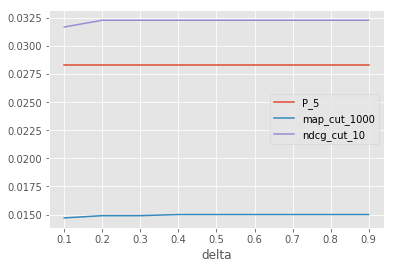

In [94]:
scores_jm = test_hyperparameters(np.arange(0.1,0.91,0.1),'jelinek_mercer_lambda',jelinek_mercer)
scores_jm.drop('recall_1000',axis=1).plot()

Retrieving using retrievals/dirichlet_prior_mu=500


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


finished retrievals/dirichlet_prior_mu=500 in 57.135594844818115 sec
Retrieving using retrievals/dirichlet_prior_mu=600
finished retrievals/dirichlet_prior_mu=600 in 56.73421931266785 sec
Retrieving using retrievals/dirichlet_prior_mu=700
finished retrievals/dirichlet_prior_mu=700 in 54.762653827667236 sec
Retrieving using retrievals/dirichlet_prior_mu=800
finished retrievals/dirichlet_prior_mu=800 in 52.901058197021484 sec
Retrieving using retrievals/dirichlet_prior_mu=900
finished retrievals/dirichlet_prior_mu=900 in 52.76588678359985 sec
Retrieving using retrievals/dirichlet_prior_mu=1000
finished retrievals/dirichlet_prior_mu=1000 in 52.92878556251526 sec
Retrieving using retrievals/dirichlet_prior_mu=1100
finished retrievals/dirichlet_prior_mu=1100 in 52.85104990005493 sec
Retrieving using retrievals/dirichlet_prior_mu=1200
finished retrievals/dirichlet_prior_mu=1200 in 52.91534447669983 sec
Retrieving using retrievals/dirichlet_prior_mu=1300
finished retrievals/dirichlet_prior_mu

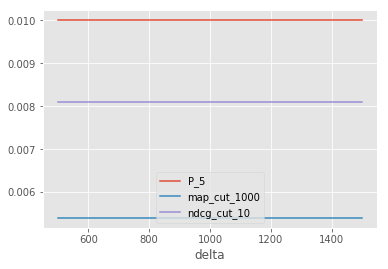

In [95]:
scores_dirich = test_hyperparameters(np.arange(500,1501, 100),'dirichlet_prior_mu',dirichlet_prior)
scores_dirich.drop('recall_1000',axis=1).plot()

Retrieving using retrievals/absolute_discounting_delta=0.1


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


finished retrievals/absolute_discounting_delta=0.1 in 63.51989388465881 sec
Retrieving using retrievals/absolute_discounting_delta=0.2
finished retrievals/absolute_discounting_delta=0.2 in 63.80004024505615 sec
Retrieving using retrievals/absolute_discounting_delta=0.30000000000000004
finished retrievals/absolute_discounting_delta=0.30000000000000004 in 63.33668875694275 sec
Retrieving using retrievals/absolute_discounting_delta=0.4
finished retrievals/absolute_discounting_delta=0.4 in 62.64584136009216 sec
Retrieving using retrievals/absolute_discounting_delta=0.5
finished retrievals/absolute_discounting_delta=0.5 in 63.44657850265503 sec
Retrieving using retrievals/absolute_discounting_delta=0.6
finished retrievals/absolute_discounting_delta=0.6 in 63.561004638671875 sec
Retrieving using retrievals/absolute_discounting_delta=0.7000000000000001
finished retrievals/absolute_discounting_delta=0.7000000000000001 in 63.33857226371765 sec
Retrieving using retrievals/absolute_discounting_de

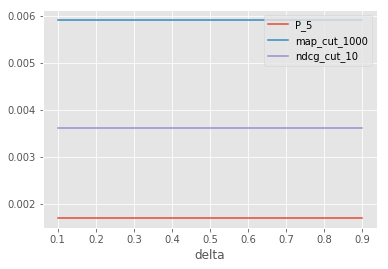

In [96]:
scores_abs_disc = test_hyperparameters(np.arange(0.1,0.91, 0.1),'absolute_discounting_delta',absolute_discounting)
scores_abs_disc.drop('recall_1000',axis=1).plot()

## Significance testing

In [97]:
ndcg_all={}

In [98]:
columns = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

ndcg = pd.DataFrame(columns=columns)

for param_value in columns:
    start_time = time.time()

    filename = 'retrievals/jelinek_mercer_lambda='+str(param_value)

    run_retrieval(filename,jelinek_mercer, lambd = param_value)

    print ('finished {} in {} sec'.format(filename,(time.time()-start_time)))

    results = !trec_eval -m all_trec -q ./ap_88_89/qrel_test { filename }.run | grep -E "^ndcg_cut_10\s"

    for result in results:
        result = re.sub( '\s+', ' ', result ).strip().split()

        idx = result[1]
        value = result[2]
        param_value = round(param_value,1)

        ndcg.set_value(idx, param_value, value)
        
ndcg_all['jelinek_mercer'] = ndcg

finished retrievals/jelinek_mercer_lambda=0.1 in 7.367134094238281e-05 sec
finished retrievals/jelinek_mercer_lambda=0.2 in 5.936622619628906e-05 sec


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Retrieving using retrievals/jelinek_mercer_lambda=0.3
finished retrievals/jelinek_mercer_lambda=0.3 in 46.78259801864624 sec
finished retrievals/jelinek_mercer_lambda=0.4 in 5.269050598144531e-05 sec
finished retrievals/jelinek_mercer_lambda=0.5 in 5.1975250244140625e-05 sec
finished retrievals/jelinek_mercer_lambda=0.6 in 6.961822509765625e-05 sec
Retrieving using retrievals/jelinek_mercer_lambda=0.7
finished retrievals/jelinek_mercer_lambda=0.7 in 46.51213479042053 sec
finished retrievals/jelinek_mercer_lambda=0.8 in 4.9114227294921875e-05 sec
finished retrievals/jelinek_mercer_lambda=0.9 in 5.316734313964844e-05 sec


In [99]:
columns = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

ndcg = pd.DataFrame(columns=columns)

for param_value in columns:
    start_time = time.time()

    filename = 'retrievals/absolute_discounting_delta='+str(param_value)

    run_retrieval(filename,jelinek_mercer, lambd = param_value)

    print ('finished {} in {} sec'.format(filename,(time.time()-start_time)))

    results = !trec_eval -m all_trec -q ./ap_88_89/qrel_test { filename }.run | grep -E "^ndcg_cut_10\s"

    for result in results:
        result = re.sub( '\s+', ' ', result ).strip().split()

        idx = result[1]
        value = result[2]
        param_value = round(param_value,1)

        ndcg.set_value(idx, param_value, value)

ndcg_all['absolute_discounting'] = ndcg

finished retrievals/absolute_discounting_delta=0.1 in 4.267692565917969e-05 sec
finished retrievals/absolute_discounting_delta=0.2 in 8.821487426757812e-05 sec


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Retrieving using retrievals/absolute_discounting_delta=0.3
finished retrievals/absolute_discounting_delta=0.3 in 46.51715111732483 sec
finished retrievals/absolute_discounting_delta=0.4 in 4.744529724121094e-05 sec
finished retrievals/absolute_discounting_delta=0.5 in 4.744529724121094e-05 sec
finished retrievals/absolute_discounting_delta=0.6 in 5.269050598144531e-05 sec
Retrieving using retrievals/absolute_discounting_delta=0.7
finished retrievals/absolute_discounting_delta=0.7 in 46.77152132987976 sec
finished retrievals/absolute_discounting_delta=0.8 in 6.341934204101562e-05 sec
finished retrievals/absolute_discounting_delta=0.9 in 4.649162292480469e-05 sec


In [100]:
columns = np.arange(500,1501,100)

ndcg = pd.DataFrame(columns=columns)

for param_value in columns:
    start_time = time.time()

    filename = 'retrievals/dirichlet_prior_mu='+str(param_value)

    run_retrieval(filename,jelinek_mercer, lambd = param_value)

    print ('finished {} in {} sec'.format(filename,(time.time()-start_time)))

    results = !trec_eval -m all_trec -q ./ap_88_89/qrel_test { filename }.run | grep -E "^ndcg_cut_10\s"

    for result in results:
        result = re.sub( '\s+', ' ', result ).strip().split()

        idx = result[1]
        value = result[2]
        param_value = round(param_value,1)

        ndcg.set_value(idx, param_value, value)

ndcg_all['dirichlet_prior'] = ndcg

finished retrievals/dirichlet_prior_mu=500 in 4.839897155761719e-05 sec
finished retrievals/dirichlet_prior_mu=600 in 4.291534423828125e-05 sec


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


finished retrievals/dirichlet_prior_mu=700 in 5.7220458984375e-05 sec
finished retrievals/dirichlet_prior_mu=800 in 6.651878356933594e-05 sec
finished retrievals/dirichlet_prior_mu=900 in 4.315376281738281e-05 sec
finished retrievals/dirichlet_prior_mu=1000 in 5.626678466796875e-05 sec
finished retrievals/dirichlet_prior_mu=1100 in 9.584426879882812e-05 sec
finished retrievals/dirichlet_prior_mu=1200 in 4.267692565917969e-05 sec
finished retrievals/dirichlet_prior_mu=1300 in 4.458427429199219e-05 sec
finished retrievals/dirichlet_prior_mu=1400 in 0.00010013580322265625 sec
finished retrievals/dirichlet_prior_mu=1500 in 4.458427429199219e-05 sec


In [105]:
tfidf_results = pd.DataFrame()

results = !trec_eval -m all_trec -q ./ap_88_89/qrel_test retrievals/tf-idf.run | grep -E "^ndcg_cut_10\s"

for result in results:
    result = re.sub( '\s+', ' ', result ).strip().split()

    index = result[1]
    value = float(result[2])

    tfidf_results.set_value(index, 1, value)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


In [106]:
bm25_results = pd.DataFrame()

results = !trec_eval -m all_trec -q ./ap_88_89/qrel_test retrievals/bm25.run | grep -E "^ndcg_cut_10\s"

for result in results:
    result = re.sub( '\s+', ' ', result ).strip().split()

    index = result[1]
    value = float(result[2])

    bm25_results.set_value(index, 1, value)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


In [107]:
best_scores = pd.DataFrame()
best_scores['absolute_discounting'] = ndcg_all['absolute_discounting'][0.1]
best_scores['jelinek_mercer'] = ndcg_all['jelinek_mercer'][0.1]
best_scores['dirichlet_prior'] = ndcg_all['dirichlet_prior'][1500]

best_scores['tf-idf'] = tfidf_results
best_scores['BM25'] = bm25_results


best_scores = best_scores.applymap(lambda x: float(x))

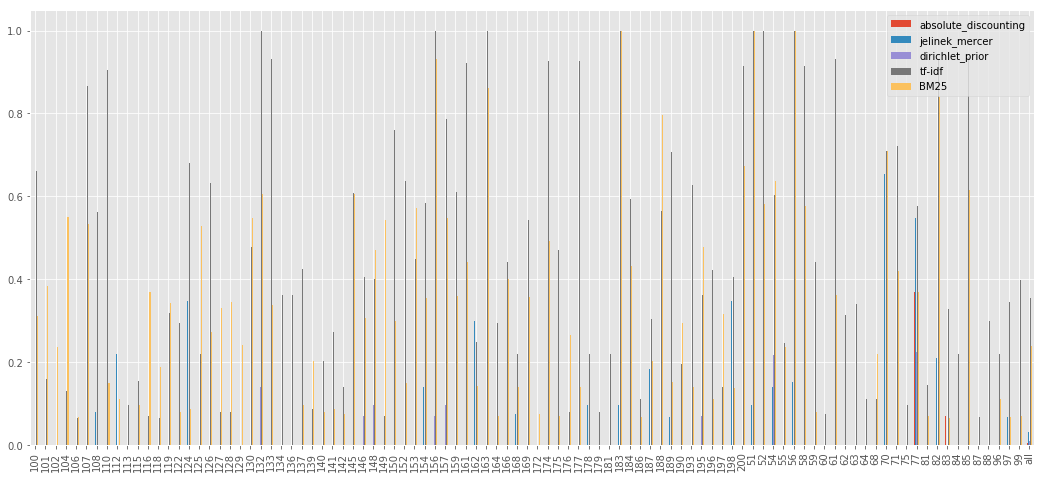

In [108]:
#plot non-zero queries only
best_scores[best_scores.sum(axis=1)>0].plot(kind='bar',figsize=(18,8))

In [110]:
def t_test(method1,method2,a=0.05):
    
    p_value = ttest_rel(method1, method2)[1]
    
    if p_value>a:
        return (p_value, 'not-rejected')
    else:
        return (p_value, 'rejected')

In [113]:
combs = list(combinations(best_scores.columns,2))

for pair in combs:
    print(pair[0],pair[1])
    print(t_test(best_scores[pair[0]],best_scores[pair[1]],a=0.05/len(combs)))
    print('\n')

absolute_discounting jelinek_mercer
(0.0006635491757109781, 'rejected')


absolute_discounting dirichlet_prior
(0.12229634841292517, 'not-rejected')


absolute_discounting tf-idf
(1.7187305535185832e-21, 'rejected')


absolute_discounting BM25
(7.162814821067257e-17, 'rejected')


jelinek_mercer dirichlet_prior
(0.0069857594896111964, 'not-rejected')


jelinek_mercer tf-idf
(1.2245460323695008e-19, 'rejected')


jelinek_mercer BM25
(2.852203769799594e-14, 'rejected')


dirichlet_prior tf-idf
(1.4167952494401046e-21, 'rejected')


dirichlet_prior BM25
(3.932989715701927e-17, 'rejected')


tf-idf BM25
(2.669411054179365e-07, 'rejected')




### Task 2: Latent Semantic Models (LSMs) [20 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

Perform analysis **[5 points]**

### Task 3:  Word embeddings for ranking [10 points] ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).

Try one of the following (increasingly complex) methods for building query and document representations:
   * Average or sum the word vectors.
   * Cluster words in the document using [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and use the centroid of the most important cluster. Experiment with different values of K for k-means.
   * Using the [bag-of-word-embeddings representation](https://ciir-publications.cs.umass.edu/pub/web/getpdf.php?id=1248).
   
Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

In [229]:
## Create embeddings
start_time = time.time()
print('Initializing word2vec.')

word2vec_init = gensim.models.Word2Vec(
    size=300,  # Embedding size
    window=5,  # One-sided window size
    sg=True,  # Skip-gram.
    min_count=1,  # Minimum word frequency.
    sample=1e-3,  # Sub-sample threshold.
    hs=False,  # Hierarchical softmax.
    negative=10,  # Number of negative examples.
    iter=1,  # Number of iterations.
    workers=8,  # Number of workers.
)

index = pyndri.Index('index/')

print('Loading vocabulary.')
dictionary = pyndri.extract_dictionary(index)
sentences = pyndri.compat.IndriSentences(index, dictionary)

print('Constructing word2vec vocabulary.')

# Build vocab.
word2vec_init.build_vocab(sentences, trim_rule=None)
model = word2vec_init
# models = [word2vec_init]

# for epoch in range(1, 1 + 1):
#     print('Epoch ', epoch)
#     epoch_time = time.time()
    
#     model = copy.deepcopy(models[-1])
#     model.train(sentences, total_examples = model.corpus_count, epochs=model.iter)

#     models.append(model)
#     print('Elapsed time for model', epoch, ':', time.time() - epoch_time)

print('Trained models:', len(models))
print('Elapsed time:', time.time()-start_time)

Initializing word2vec.
Loading vocabulary.
Constructing word2vec vocabulary.
Trained models: 2
Elapsed time: 51.66001629829407


In [265]:
def run_w2v_retrieval(model_name, score_fn, **args):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    run_out_path = '{}.run'.format(model_name)

    if os.path.exists(run_out_path):
        return

    retrieval_start_time = time.time()

    print('Retrieving using', model_name)

    data = {}
    
    for qid in tokenized_queries.keys(): #for each query
#     for qid in ['93']: #test

        score = {}
        
        for query_term_id in tokenized_queries[qid]: #for each word_id in query

            for (int_document_id,document_term_freq) in zip(inverted_index[query_term_id].keys(),inverted_index[query_term_id].values()):
                #for each document where the word appears, calculate scoring function increment its score
                new_score = score_fn(int_document_id, qid)
                
                if int_document_id not in score.keys():
                    #print('initiallizing and incrementing score')
                    score[int_document_id] = new_score
                else:
                    #print('incrementing score')
                    score[int_document_id] += new_score

        #turn dict to list of tuples and continue        
        # The dictionary data should have the form: query_id --> (document_score, external_doc_id)
        data[qid] = [(score, index.ext_document_id(doc_id)) for (score, doc_id) in zip(score.values(), score.keys())]
                
#     write out
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,

            max_objects_per_query=1000)

In [288]:
## Sum all query vectors (normalized)
summed_queries = {}
for qid in tokenized_queries.keys(): #for each query
    
    Q = []
    for query_term_id in tokenized_queries[qid]: #for each word_id in query
        term = dictionary[query_term_id]
        Q.append(model[term])
        
    Q = np.array(Q)
    vector = Q.sum(axis=0) 
#     vector = vector / np.sqrt((vector ** 2).sum())

    summed_queries[qid] = vector   

## Sum all document vectors (normalized)    
summed_docs = {}
for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)
        
    D = []
    for token_id in doc_token_ids: 
        if token_id > 0:
            term = dictionary[query_term_id]
            D.append(model[term])
    D = np.array(D)
    vector = D.sum(axis=0) 
#     vector = vector / np.sqrt((vector ** 2).sum())

    summed_docs[int_doc_id] = vector

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


## Sum of vectors

In [282]:
def summed_vectors(document_id, query_id):
    """
    Scoring function for a document and a query term
    
    :param document_id: the document id
    :param query_id: the tokenized query id
    """
    
    cosine_similarity = np.dot(summed_queries[query_id], summed_docs[document_id])/(np.linalg.norm(summed_queries[query_id])* np.linalg.norm(summed_docs[document_id]))
        
    return cosine_similarity

In [290]:
start_time = time.time()

run_w2v_retrieval('retrievals/summed_vectors',summed_vectors)

print ('elapsed time:',time.time()-start_time)

Retrieving using retrievals/summed_vectors
elapsed time: 69.08982968330383


In [301]:
# trec_eval command for evalutaion of summed_vectors
!trec_eval -m all_trec ./ap_88_89/qrel_validation retrievals/summed_vectors.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"
print('\n')

# trec_eval command for test of summed_vectors
!trec_eval -m all_trec ./ap_88_89/qrel_test retrievals/summed_vectors.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.1000
recall_1000           	all	0.3682
ndcg_cut_10           	all	0.0916
map_cut_1000          	all	0.0806


P_5                   	all	0.1250
recall_1000           	all	0.3280
ndcg_cut_10           	all	0.1293
map_cut_1000          	all	0.0604


## Average of vectors

In [298]:
def averaged_vectors(document_id, query_id):
    """
    Scoring function for a document and a query term
    
    :param document_id: the document id
    :param query_id: the tokenized query id
    """
    
    query_vector = summed_queries[query_id] / len(tokenized_queries[qid])
    doc_vector = summed_docs[document_id] / document_lengths[document_id]
    
    
    cosine_similarity = np.dot(query_vector, doc_vector)/(np.linalg.norm(query_vector)* np.linalg.norm(doc_vector))
        
    return cosine_similarity

In [299]:
start_time = time.time()

run_w2v_retrieval('retrievals/averaged_vectors',averaged_vectors)

print ('elapsed time:',time.time()-start_time)

Retrieving using retrievals/averaged_vectors
elapsed time: 89.72392344474792


In [300]:
# trec_eval command for evalutaion of averaged vectors
!trec_eval -m all_trec ./ap_88_89/qrel_validation retrievals/averaged_vectors.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"
print('\n')

# trec_eval command for test of averaged vectors
!trec_eval -m all_trec ./ap_88_89/qrel_test retrievals/averaged_vectors.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.1133
recall_1000           	all	0.3680
ndcg_cut_10           	all	0.1009
map_cut_1000          	all	0.0809


P_5                   	all	0.1283
recall_1000           	all	0.3280
ndcg_cut_10           	all	0.1278
map_cut_1000          	all	0.0610


## K-means clustering

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

start_time = time.time()

## Define vector and clusters
vectors = model.wv.syn0
clusters = 100

## Initialize clustering
kmeans_clustering = KMeans(n_clusters = clusters)
result = kmeans_clustering.fit_predict(vectors)

word_centroid_map = dict(zip( model.wv.index2word, result ))
print('Elapsed time:', time.time()-start_time)

In [ ]:
start_time = time.time()
for cluster in range(0,100):
    words = []

    for word, cluster_idx in word_centroid_map.items():
        if(cluster_idx == cluster ):
            words.append(word)
    print('Cluster ', cluster, ' amount of words: ', len(words))
    
print('Elapsed time:', time.time()-start_time)

### Task 4: Learning to rank (LTR) [10 points] ###

In this task you will get an introduction into learning to rank for information retrieval, in particular pointwise learning to rank.

You will experiment with a pointwise learning to rank method, logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1 and Task 2 as features. Think about other features you can use (e.g. query/document length). 
One idea is to also explore external sources such as Wikipedia entities (?). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

### Task 4: Write a report [20 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.
